# Kriging

In [139]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## Preamble

In this preamble, we load the **gstlearn** library.

In [140]:
import gstlearn as gl
import gstlearn.plot as gp
import matplotlib.pyplot as plt
import numpy as np
import os
import urllib.request

flagInternetAvailable = True ## Set to false if no internet

Then we download the data base `dat`.

In [141]:
fileNF='Scotland_Temperatures.NF'
if flagInternetAvailable:
    temp_nf, head = urllib.request.urlretrieve('https://soft.minesparis.psl.eu/gstlearn/data/Scotland/'+fileNF,'./'+fileNF)
else:
    temp_nf='./'+fileNF

dat = gl.Db.createFromNF(temp_nf)

We also create a `Db` object containing a grid covering the data points in the data base `dat`. To do so, we start by displaying the minimal and maximal coordinates of the points in `dat` using the `getExtremas()` method from the `Db` class.

In [142]:
dat.getExtremas()

array([[  78.2,  460.7],
       [ 530.4, 1208.9]])

The first (resp. second) element of the list contains the min and max coordinates in the first (resp. second) space dimension. Based on this information, we create a grid covering all the points using the `DbGrid_create` function. We specify the coordinates of the origin (i.e. lower left corner) of the grid (argument `x0`), the step sizes in each dimension (argument `dx`) and the number of points in each dimension (argument `nx`).

In [143]:
grid = gl.DbGrid.create(x0=[65,530],dx=[4.94, 4.96],nx=[82,138])

We then print a summary of the content of the grid using the `display` method of `Db` class, which we supply with a `DbStringFormat` object specifying that we would like information about the extent of the grid (argument `flag_extend` in the `DbStringFormat_createFromFlags` function).

In [144]:
dbfmt = gl.DbStringFormat.createFromFlags(flag_extend=True)
grid.display(dbfmt)


Data Base Grid Characteristics

Data Base Summary
-----------------
File is organized as a regular grid
Space dimension              = 2
Number of Columns            = 3
Maximum Number of UIDs       = 3
Total number of samples      = 11316

Grid characteristics:
---------------------
Origin :     65.000   530.000
Mesh   :      4.940     4.960
Number :         82       138

Data Base Extension
-------------------
Coor #1 - Min =     65.000 - Max =    465.140 - Ext = 400.14
Coor #2 - Min =    530.000 - Max =   1209.520 - Ext = 679.52

Variables
---------
Column = 0 - Name = rank - Locator = NA
Column = 1 - Name = x1 - Locator = x1
Column = 2 - Name = x2 - Locator = x2
 

## Experimental Variogram and fitted Model

We compute the experimental variogram **vario2dir** (in 2 directions) (cf. [Variography](./04_Variography.ipynb) for more details).

In [145]:
varioParamMulti = gl.VarioParam.createMultiple(ndir=2, npas=15, dpas=15.)
vario2dir = gl.Vario(varioParamMulti, dat)
err = vario2dir.compute()

We then the fit a model **fitmod**

In [146]:
fitmod = gl.Model()
types=[gl.ECov.NUGGET, gl.ECov.EXPONENTIAL, gl.ECov.GAUSSIAN]
err = fitmod.fit(vario2dir,types=types)

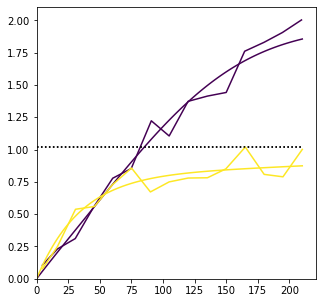

In [147]:
ax = gp.varmod(vario2dir, fitmod)

## Simple kriging prediction

To perform simple kriging, we use the function called `kriging`. 
We specify:

* the `Db` object containing the data points (argument `dbin`) : the variable used for kriging is the (unique) variable of the data base  with a `z` locator (i.e. it should have locator `z1` and the other variables should not have a locator starting with `z`)
* the `Db` object containing the target points, i.e. the points where the kriging predictor will be computed (argument `dbout`)
* the `Model` object containing the model used to define the kriging predictor (argument `model`): in particular, the mean used to define the predictor is the one set in the `Model` object
* the type of neighborhood used in the prediction (argument `neigh`), eg. unique neighborhood (to use all the data points for each predictor) or moving neighborhood (to use only the data points in the vicinity of the target point in the prediction). This argument is defined using a "neighborhood" object (see example below).

Additionally, it is possible to specify whether we wish to compute, at each target point, the kriging predictor (argument `flag_est`, default=`TRUE`), the kriging standard-deviation (argument `flag_std`, default=`TRUE`) and the kriging variance (argument `flag_varz`, default=`FALSE`). 

The `kriging` function then adds new variables to the `Db` entered in the `dbout` argument corresponding to these variables. The names of these newly created variables will start by `Kriging`, but this prefix can be changed using the `namconv` argument of the `kriging function`

In the next example, we perform a simple kriging prediction (with unique neighborhood) of the variable `January_temp` in the `dat` data base,  on the grid defined in the `grid` data base. To do so, we start by selecting the variable `January_temp` in the `dat` data base (i.e. we make ensure that it is the only variable with a `z` locator).

In [148]:
dat.setLocator("January_temp",gl.ELoc.Z)
dat


Data Base Characteristics

Data Base Summary
-----------------
File is organized as a set of isolated points
Space dimension              = 2
Number of Columns            = 5
Maximum Number of UIDs       = 5
Total number of samples      = 236

Variables
---------
Column = 0 - Name = rank - Locator = NA
Column = 1 - Name = Longitude - Locator = x1
Column = 2 - Name = Latitude - Locator = x2
Column = 3 - Name = Elevation - Locator = NA
Column = 4 - Name = January_temp - Locator = z1

We then create a "neighborhood" object corresponding to the specification of a unique neighborhood: this is done using the `NeighUnique` function.

In [149]:
uniqueNeigh = gl.NeighUnique.create()

We now call the `kriging` function to perform the kriging prediction. We use the model `fitmod` that we previously fitted on our data, require to compute the kriging predictor and its standard-deviation (but not its variance), and change the prefix of the newly created variables to "SK".

In [150]:
err = gl.kriging(dbin=dat, dbout=grid, model=fitmod, 
              neigh=uniqueNeigh,
              flag_est=True, flag_std=True, flag_varz=False,
              namconv=gl.NamingConvention("SK")
              )

We see that the kriging predictor and its standard deviation have been added to the `grid` data base.

In [151]:
grid


Data Base Grid Characteristics

Data Base Summary
-----------------
File is organized as a regular grid
Space dimension              = 2
Number of Columns            = 5
Maximum Number of UIDs       = 5
Total number of samples      = 11316

Grid characteristics:
---------------------
Origin :     65.000   530.000
Mesh   :      4.940     4.960
Number :         82       138

Variables
---------
Column = 0 - Name = rank - Locator = NA
Column = 1 - Name = x1 - Locator = x1
Column = 2 - Name = x2 - Locator = x2
Column = 3 - Name = SK.January_temp.estim - Locator = z1
Column = 4 - Name = SK.January_temp.stdev - Locator = NA

Finally, we plot the kriging prediction over the grid and the data points.

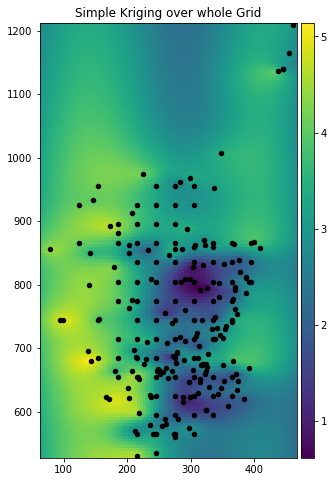

In [152]:
gp.setDefaultGeographic(dims=[8,8])

fig, ax = gp.initGeographic()
ax.raster(grid, flagLegend=True)
ax.symbol(dat, c='black')
ax.decoration(title="Simple Kriging over whole Grid")
plt.show()

By default, the plotting function plots the variable with locator `z1`, which in our case corresponds to the kriging predictor (as the `kriging` function automatically assigns the locator `z1` to it). To plot another variable, we can simply specify their name. 

For instance, we can plot the kriging standard deviation using the following code.

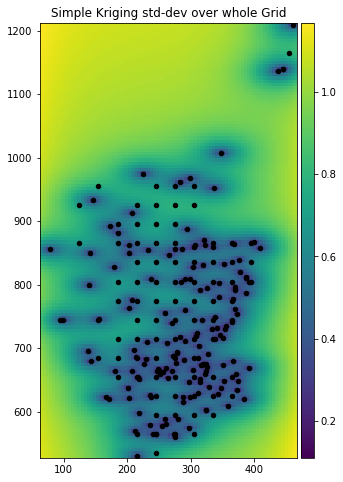

In [153]:
fig, ax = gp.initGeographic()
ax.raster(grid, name="SK.January_temp.stdev", flagLegend=True)
ax.symbol(dat, c='black')
ax.decoration(title="Simple Kriging std-dev over whole Grid")
plt.show()

As mentioned above, the mean used in the simple kriging predictor is the one set in the `Model` object supplied in the `kriging` function. By default, this mean is zero. It can be changed using the `setMean` method of the `Model` object. 

For instance, considering the model `fitmod` previously fitted on the data, we can clone it (using the `clone` method), and assign it a new mean (equal to 4) as follows.

In [154]:
fitmodSK = fitmod.clone()
err = fitmodSK.setMean(mean=4)

Then, simple kriging is performed using the same command as before, but with the newly created model.

In [155]:
err = gl.kriging(dbin=dat, dbout=grid, model=fitmodSK, 
              neigh=uniqueNeigh,
              flag_est=True, flag_std=True, flag_varz=False,
              namconv=gl.NamingConvention("Mean4_SK")
              )

Finally, we plot the new kriging prediction over the grid and the data points. 

In [156]:
grid


Data Base Grid Characteristics

Data Base Summary
-----------------
File is organized as a regular grid
Space dimension              = 2
Number of Columns            = 7
Maximum Number of UIDs       = 7
Total number of samples      = 11316

Grid characteristics:
---------------------
Origin :     65.000   530.000
Mesh   :      4.940     4.960
Number :         82       138

Variables
---------
Column = 0 - Name = rank - Locator = NA
Column = 1 - Name = x1 - Locator = x1
Column = 2 - Name = x2 - Locator = x2
Column = 3 - Name = SK.January_temp.estim - Locator = NA
Column = 4 - Name = SK.January_temp.stdev - Locator = NA
Column = 5 - Name = Mean4_SK.January_temp.estim - Locator = z1
Column = 6 - Name = Mean4_SK.January_temp.stdev - Locator = NA

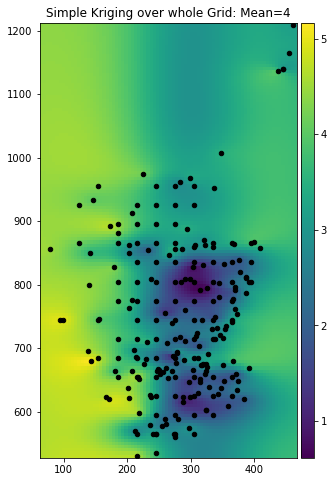

In [157]:
fig, ax = gp.initGeographic()
ax.raster(grid, name="Mean4_SK.January_temp.estim", flagLegend=True)
ax.symbol(dat, c='black')
ax.decoration(title="Simple Kriging over whole Grid: Mean=4")
plt.show()

## Ordinary kriging

In gstlearn, ordinary kriging is seen as the formulation of a kriging predictor on a model with a constant drift. Hence, to perform ordinary kriging, we use the `kriging` function with the same syntax as for simple kriging, but call it with a model that includes a constant drift. Adding a constant drift to a model is done with the `addDrift1()` method. 

Note: Removing a drift from a model can be done using the `delDrift` method (while specifying the index of the drift we wish to remove) or using the `delAllDrifts()` (to remove all the drifts at once).

Let us go back to our running example. Considering the model `fitmod` previously fitted on the data, we can clone it (using the `clone` method), and add a constant drift as follows.

In [158]:
fitmodOK = fitmod.clone()
err = fitmodOK.addDrift(gl.Drift1())

Then, ordinary kriging is performed using the same command as before, but with the newly created model.

In [159]:
err = gl.kriging(dbin=dat, dbout=grid, model=fitmodOK, 
              neigh=uniqueNeigh,
              flag_est=True, flag_std=True, flag_varz=False,
              namconv=gl.NamingConvention("OK")
              )

Finally, we plot the new kriging prediction over the grid and the data points. 

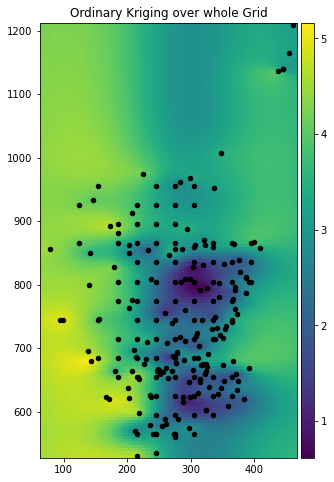

In [160]:
fig, ax = gp.initGeographic()
ax.raster(grid, name="OK.January_temp.estim", flagLegend=True)
ax.symbol(dat, c='black')
ax.decoration(title="Ordinary Kriging over whole Grid")
plt.show()

We also plot the kriging standard deviations.

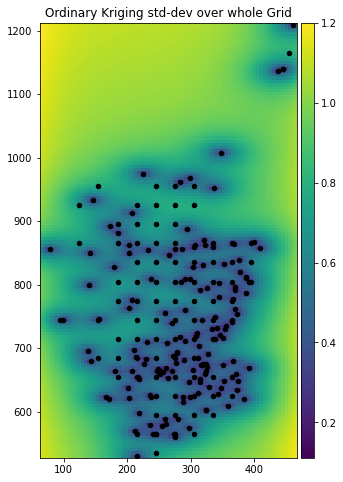

In [161]:
fig, ax = gp.initGeographic()
ax.raster(grid, name="OK.January_temp.stdev", flagLegend=True)
ax.symbol(dat, c='black')
ax.decoration(title="Ordinary Kriging std-dev over whole Grid")
plt.show()

Let us compare the results from the simple and ordinary kriging predictors. To do so, we create a correlation plot between the two predictors.

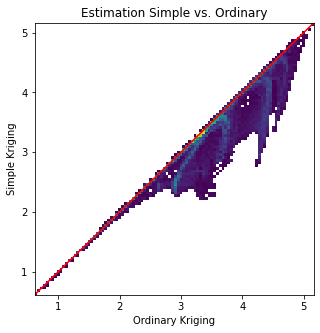

In [162]:
ax = gp.correlation(grid,namex="OK.January_temp.estim", namey="SK.January_temp.estim", 
                    bissLine=True, bins=100, flagSameAxes=True, cmin=1)
ax.decoration(title="Estimation Simple vs. Ordinary", 
              xlabel="Ordinary Kriging", ylabel="Simple Kriging")

We also compare the kriging standard-deviations obtained in both cases.

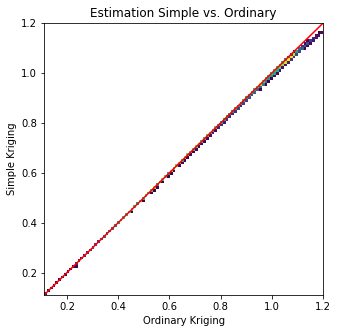

In [163]:
ax = gp.correlation(grid,namex="OK.January_temp.stdev", namey="SK.January_temp.stdev", 
                    bissLine=True, bins=100, flagSameAxes=True, cmin=1)
ax.decoration(title="Estimation Simple vs. Ordinary", 
              xlabel="Ordinary Kriging", ylabel="Simple Kriging")

## Working with selections

We now load new grid. 

In [164]:
fileNF='Scotland_Elevations.NF'
if flagInternetAvailable:
    elev_nf, head = urllib.request.urlretrieve('https://soft.minesparis.psl.eu/gstlearn/data/Scotland/'+fileNF,'./'+fileNF)
else:
    elev_nf='./'+fileNF
    
grid = gl.DbGrid.createFromNF(elev_nf)
grid.display(dbfmt)


Data Base Grid Characteristics

Data Base Summary
-----------------
File is organized as a regular grid
Space dimension              = 2
Number of Columns            = 4
Maximum Number of UIDs       = 4
Total number of samples      = 11097
Number of active samples     = 3092

Grid characteristics:
---------------------
Origin :     65.000   535.000
Mesh   :      4.938     4.963
Number :         81       137

Data Base Extension
-------------------
Coor #1 - Min =     65.000 - Max =    455.123 - Ext = 390.123
Coor #2 - Min =    535.000 - Max =   1200.109 - Ext = 665.109

Variables
---------
Column = 0 - Name = Longitude - Locator = x1
Column = 1 - Name = Latitude - Locator = x2
Column = 2 - Name = Elevation - Locator = f1
Column = 3 - Name = inshore - Locator = sel
 

This new grid data base contains a variable called `inshore`, with a locator `sel`. This indicates that this variable is a selection, i.e. a binary variable allowing to select some points, called *active cells*, in a data base (by setting them to 1, while the other points will be 0). Selections allow to restrict computations and operations made on a data base to only the active cells. For, when plotting a data base with a selection, only the active cells are represented.

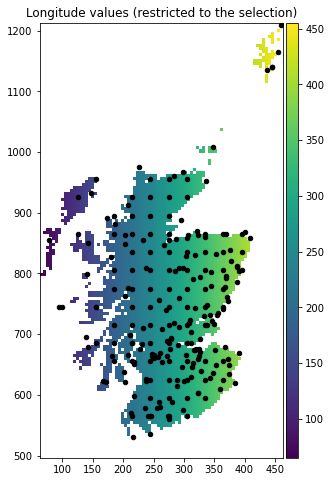

In [165]:
fig, ax = gp.initGeographic()
ax.raster(grid, name="Longitude", flagLegend=True)
ax.symbol(dat, c='black')
ax.decoration(title="Longitude values (restricted to the selection)")
plt.show()

When calling the `kriging` function on a data base that contains a selection, the predictors are only computed on the active cells (while the other cells are left undefined).

In [166]:
err = gl.kriging(dbin=dat, dbout=grid, model=fitmodOK, neigh=uniqueNeigh,
              flag_est=True, flag_std=True, flag_varz=False,
              namconv=gl.NamingConvention("OK"))

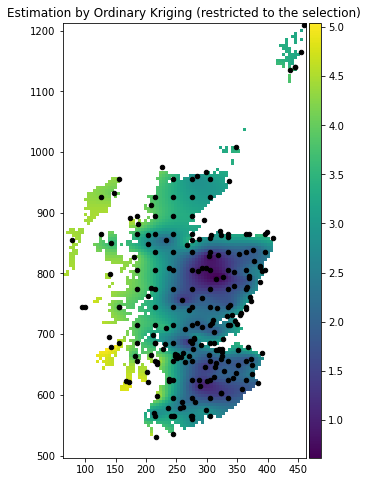

In [167]:
fig, ax = gp.initGeographic()
ax.raster(grid, name="OK*estim", flagLegend=True)
ax.symbol(dat, c='black')
ax.decoration(title="Estimation by Ordinary Kriging (restricted to the selection)")
plt.show()

## Cross-validation

The function `xvalid` can be used to perform leave-one-out cross-validation with kriging: each point of the data base is separately predicted by kriging, using all the other points in the data base. This function is called in a similar way as the `kriging` function. We specify:

* the `Db` object containing the data points on which we want to perform the cross-validation  (argument `dbin`) : once again, the variable used for the study is the (unique) variable of the data base  with a `z` locator
* the `Model` object containing the model used to define the kriging predictor (argument `model`)
* the type of neighborhood used in the prediction (argument `neigh`)
* whether we wish to return, for each point, only the predictor (argument `flag_xvalid_est=-1`, returns a variable with name ending with "estim"), the cross-validation error defined as the difference between the predictor and the true value (argument `flag_xvalid_est=1`, returns a variable with name ending with "esterr") or neither (argument `flag_xvalid_est=0`)
* whether we wish to return, for each point, only the kriging standard-deviation at each point (argument `flag_xvalid_std=-1`, returns a variable with name ending with "stdev"), a standardized error defined as the ratio (Cross-validation error)/(Kriging standard-deviation) (argument `flag_xvalid_std=1`, returns a variable with name ending with "stderr") or neither (argument `flag_xvalid_std=0`)

Going back to our running example, we perform a cross-validation on our data base `dat`. In particular we ask, at each point, for the cross-validation error and for the standardized error described above. We also specify, through the `nameconv` that we do not wish to modify the current locators in the data base (otherwise, the locator `z1` is "moved" to the variable containing the cross-validation error).

In [168]:
err = gl.xvalid(db=dat, model=fitmodOK, neigh=uniqueNeigh, 
             flag_xvalid_est=1, flag_xvalid_std=1,  
             namconv=gl.NamingConvention.create("Xvalid", flag_locator = False)
            )

We plot the histogram of cross-validation errors.

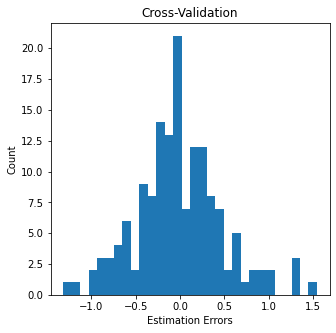

In [169]:
ax = gp.histogram(dat,name="*esterr*",bins=30,fill="blue")
ax.decoration(xlabel="Estimation Errors",title="Cross-Validation")

We plot the histogram of standardized errors.

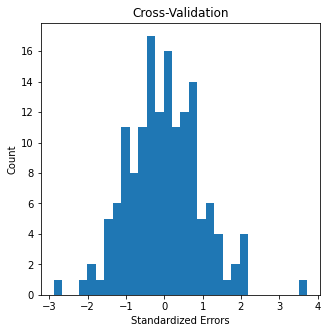

In [170]:
ax = gp.histogram(dat,name="*stderr*",bins=30,fill="blue")
ax.decoration(xlabel="Standardized Errors", title="Cross-Validation")

Finally, we compute a few statistics about these errors.

In [171]:
print("Mean cross-validation error:",round(np.nanmean(dat.getColumn("*esterr*")),4))
print("Mean squared cross-validation error:",round(np.nanmean(np.square(dat.getColumn("*esterr*"))),4))
print("Mean standardized error:",round(np.nanmean(np.square(dat.getColumn("*stderr*"))),4))

Mean cross-validation error: -0.0042
Mean squared cross-validation error: 0.2394
Mean standardized error: 0.9118


We now plot the absolute value of the cross-validation errors at each point on top of the grid map. We use the argument `flagAbsSize = TRUE` in the `plot.point` function to specify that we want the size of the points to be proportional to the absolute value of the variable specified in the `name_size` argument (here, the cross-validation errors).

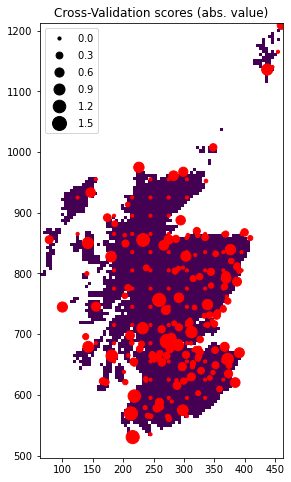

In [172]:
fig, ax = gp.initGeographic()
ax.raster(grid, name="inshore")
ax.symbol(dat,name_size="*esterr", flagAbsSize=True, flagLegend=True)
ax.decoration(title="Cross-Validation scores (abs. value)")
plt.show()

## Kriging with moving neighborhood

Up until now, we only considered kriging with a unique neighborhood. To work with a moving neighborhood, we first need to define it by creating "neighborhood" object describing its characteristics. This is done using the `NeighMoving_create` function. We can specify:

* a neighborhood radius (argument `radius`, default=1.234e30): note that the default radius value is taken very large so that the neighborhood radius can basically be seen as infinite if the argument is not set by the user
* the minimum and maximum number of data points (within the specified radius) that should be included in the neighborhood (respectively through the arguments `nmini` and `nmaxi`): for a given target point, if the number of data points within the neighborhood radius is smaller that the specified minimum, then no prediction is performed at this target (it is set to undefined)

For instance, to design a small Moving Neighborhood with only 1 sample per neighborhood (irregardless of its distance to the target point), we use the following command:


In [173]:
smallNeigh = gl.NeighMoving.create(nmini=1, nmaxi=1)

Then, (ordinary) kriging with moving neighborhood is performed using the same commands as before, but replacing the unique neighborhood in the `neigh` argument by our custom moving neighborhood object.

In [174]:
err = gl.kriging(dbin=dat, dbout=grid, model=fitmodOK, neigh=smallNeigh,
              flag_est=True, flag_std=True, 
              namconv=gl.NamingConvention("Small"))

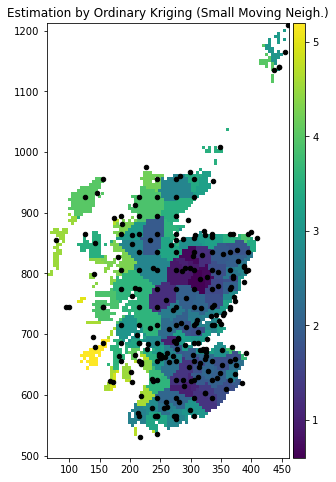

In [175]:
fig, ax = gp.initGeographic()
ax.raster(grid, name="Small*estim", flagLegend=True)
ax.symbol(dat, c='black')
ax.decoration(title="Estimation by Ordinary Kriging (Small Moving Neigh.)")
plt.show()

To create a moving neighborhood with radius 20 and containing between 1 and 10 points, we use the following command:

In [176]:
movingNeigh = gl.NeighMoving.create(nmini=1, nmaxi=10, radius=20)

Running the Ordinary Kriging then gives:

In [177]:
err = gl.kriging(dat,grid,fitmodOK,movingNeigh,
              flag_est=True, flag_std=True, 
              namconv=gl.NamingConvention("Reduced"))

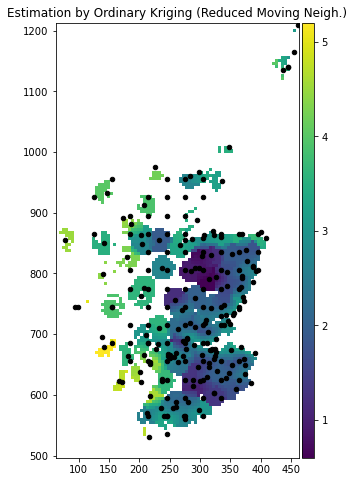

In [178]:
fig, ax = gp.initGeographic()
ax.raster(grid, name="Reduced*estim", flagLegend=True)
ax.symbol(dat, c='black')
ax.decoration(title="Estimation by Ordinary Kriging (Reduced Moving Neigh.)")
plt.show()

Note that some of the target sites are not predicted as no sample is found within their neighborhood.

Let us then consider a moving neighborhood with a bigger radius (150) and containing between 1 and 10 points.

In [179]:
movingNeigh = gl.NeighMoving.create(nmini=1, nmaxi=10, radius=150)

Running the Ordinary Kriging then gives:

In [180]:
err = gl.kriging(dat,grid,fitmodOK,movingNeigh,
              flag_est=True, flag_std=True, 
              namconv=gl.NamingConvention("Moving"))

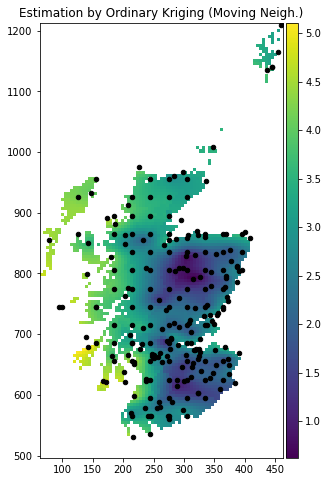

In [181]:
fig, ax = gp.initGeographic()
ax.raster(grid, name="Moving*estim", flagLegend=True)
ax.symbol(dat, c='black')
ax.decoration(title="Estimation by Ordinary Kriging (Moving Neigh.)")
plt.show()

And plotting the associated kriging standard-deviations gives:

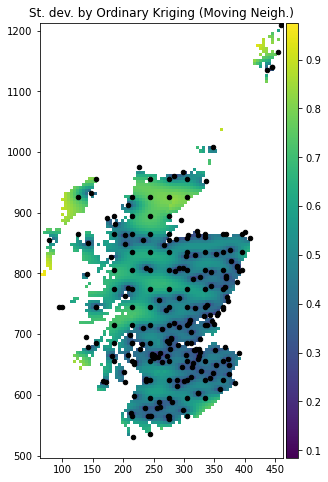

In [182]:
fig, ax = gp.initGeographic()
ax.raster(grid, name="Moving*stdev", flagLegend=True)
ax.symbol(dat, c='black')
ax.decoration(title="St. dev. by Ordinary Kriging (Moving Neigh.)")
plt.show()

Finally, let us compare the results obtained with a unique and a moving neighborhood (through correlation plot). First, we compare the kriging predictions in both cases.

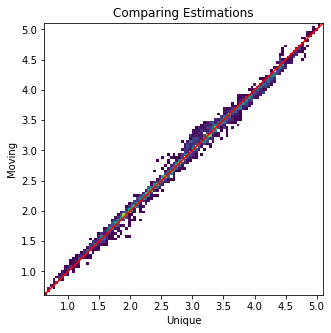

In [183]:
ax = gp.correlation(grid,namex = "OK*estim",namey="Moving*estim", 
                    bins=100, bissLine=True, flagSameAxes=True, cmin=1)
ax.decoration(title="Comparing Estimations", xlabel="Unique", ylabel="Moving")

Then, we compare the kriging standard-deviations in both cases.

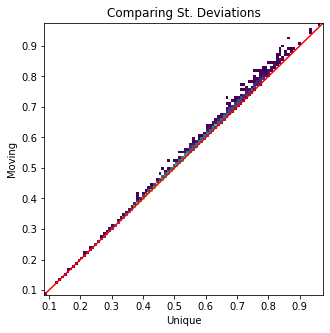

In [184]:
ax = gp.correlation(grid,namex = "OK*stdev",namey="Moving*stdev", 
                    bins=100, bissLine=True, flagSameAxes=True, cmin=1)
ax.decoration(title="Comparing St. Deviations", xlabel="Unique", ylabel="Moving")